In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch.nn.functional as F
from tqdm import tqdm
import copy
import collections

In [3]:
def gen_data(n, d, p, scale=1.0):
    ys = torch.distributions.Bernoulli(torch.tensor(p)).sample((n, 1))
    zs = torch.randn(n, d)
    xs = zs + scale * (2*ys-1)
    return xs.float(), ys

In [4]:
def source_target_dist(eps):
    return eps.abs().sum(dim = 0).max()

In [5]:
def cdf(mu, sigma, x):
    return 0.5 * (1 + torch.erf((x - mu) / (sigma * np.sqrt(2))))

In [6]:
ps = .5
ms = 1.
ss = 1.0

mus = torch.tensor([-ms, ms])
sigmas = torch.tensor([ss, ss])

pt = .8
mt = 2.
st = 1.0

mut = torch.tensor([-mt, mt])
sigmat = torch.tensor([st, st])

In [19]:
ccps = torch.zeros(2, 2)
ccps[0, 0] = cdf(mus[0], sigmas[0], 0.0)
ccps[0, 1] = cdf(mus[1], sigmas[1], 0.0)
ccps[1, 0] = 1 - ccps[0, 0]
ccps[1, 1] = 1 - ccps[0, 1]

cs = torch.zeros(2, 2)
cs[:, 0] = ccps[:, 0] * (1 - ps)
cs[:, 1] = ccps[:, 1] * ps


ccpt = torch.zeros(2, 2)
ccpt[0, 0] = cdf(mut[0], sigmat[0], 0.0)
ccpt[0, 1] = cdf(mut[1], sigmat[1], 0.0)
ccpt[1, 0] = 1 - ccpt[0, 0]
ccpt[1, 1] = 1 - ccpt[0, 1]

ct = torch.zeros(2, 2)
ct[:, 0] = ccpt[:, 0] * (1 - pt)
ct[:, 1] = ccpt[:, 1] * pt

eps = ccpt - ccps

In [20]:
muPred = torch.zeros(2)
muPred[0] = cdf(mut[0], sigmat[0], 0.0) * (1-pt) + cdf(mut[1], sigmat[1], 0.0) * pt
muPred[1] = 1 - muPred[0]

In [21]:
muTrue = torch.zeros(2)
muTrue[0] = 1 - pt
muTrue[1] = pt

In [22]:
lambdaMin = torch.linalg.eig(cs)[0].abs().min()
cInv = torch.inverse(cs)
wPred = cInv @ muPred

In [23]:
wTrue = torch.zeros(2)
wTrue[0] = (1-pt) / (1-ps)
wTrue[1] = pt / ps

In [24]:
trueDist = torch.norm(wTrue - wPred)
trueDist

tensor(0.3378)

In [25]:
ourBound21 = np.sqrt(2.)/lambdaMin * source_target_dist(eps) * torch.norm(muTrue)
ourBound21

tensor(0.9286)

In [26]:
ourBound21/trueDist

tensor(2.7487)

In [27]:
eps = ccpt - ccps
lambdaMax = torch.linalg.eig(eps)[0].abs().max()
ourBound19 = lambdaMax / lambdaMin * torch.norm(muTrue)
ourBound19

tensor(0.6566)

In [28]:
ourBound19/trueDist

tensor(1.9437)

In [29]:
ourBound17 = torch.norm(cInv @ eps @ muTrue)
ourBound17

tensor(0.3378)

In [54]:
def main(ps, ms, ss, pt, mt, st):
    mus = torch.tensor([-ms, ms])
    sigmas = torch.tensor([ss, ss])
    mut = torch.tensor([-mt, mt])
    sigmat = torch.tensor([st, st])

    ccps = torch.zeros(2, 2)
    ccps[0, 0] = cdf(mus[0], sigmas[0], 0.0)
    ccps[0, 1] = cdf(mus[1], sigmas[1], 0.0)
    ccps[1, 0] = 1 - ccps[0, 0]
    ccps[1, 1] = 1 - ccps[0, 1]

    cs = torch.zeros(2, 2)
    cs[:, 0] = ccps[:, 0] * (1 - ps)
    cs[:, 1] = ccps[:, 1] * ps


    ccpt = torch.zeros(2, 2)
    ccpt[0, 0] = cdf(mut[0], sigmat[0], 0.0)
    ccpt[0, 1] = cdf(mut[1], sigmat[1], 0.0)
    ccpt[1, 0] = 1 - ccpt[0, 0]
    ccpt[1, 1] = 1 - ccpt[0, 1]

    ct = torch.zeros(2, 2)
    ct[:, 0] = ccpt[:, 0] * (1 - pt)
    ct[:, 1] = ccpt[:, 1] * pt

    eps = ccpt - ccps

    ct = torch.zeros(2, 2)
    ct[:, 0] = ccpt[:, 0] * (1 - pt)
    ct[:, 1] = ccpt[:, 1] * pt
    
    muPred = torch.zeros(2)
    muPred[0] = cdf(mut[0], sigmat[0], 0.0) * (1-pt) + cdf(mut[1], sigmat[1], 0.0) * pt
    muPred[1] = 1 - muPred[0]

    muTrue = torch.zeros(2)
    muTrue[0] = 1 - pt
    muTrue[1] = pt

    lambdaMin = torch.linalg.eig(cs)[0].abs().min()
    cInv = torch.inverse(cs)
    wPred = cInv @ muPred

    wTrue = torch.zeros(2)
    wTrue[0] = (1-pt) / (1-ps)
    wTrue[1] = pt / ps
    
    eps = ccpt - ccps
    
    ourBound21 = np.sqrt(2.)/lambdaMin * source_target_dist(eps) * torch.norm(muTrue)
    # lambdaMax = torch.linalg.eig(eps)[0].abs().max()
    # ourBound19 = lambdaMax / lambdaMin * torch.norm(muTrue)

    # ourBound18 = 1 / lambdaMin * torch.norm(eps @ muTrue)

    # ourBound17 = torch.norm(cInv @ eps @ muTrue)

    trueDist = torch.norm(wTrue - wPred)

    return trueDist, ourBound21

In [60]:
ps = .5
ms = 1.
ss = 1.0

# pt = .8
mt = .7
st = 1.0

for pt in [.5000001, .500001, .5001, .51, .6, .7, .8, .9, .99, .999, .9999, .99999, .999999, .9999999, .99999999, .999999999]:
    trueDist, ourBound21 = main(ps, ms, ss, pt, mt, st)
    print(pt, mt, st, trueDist, ourBound21, ourBound21/trueDist)

0.5000001 0.7 1.0 tensor(2.9802e-07) tensor(0.4881) tensor(1637854.3750)
0.500001 0.7 1.0 tensor(8.8609e-07) tensor(0.4881) tensor(550870.0625)
0.5001 0.7 1.0 tensor(6.9289e-05) tensor(0.4881) tensor(7044.6357)
0.51 0.7 1.0 tensor(0.0069) tensor(0.4882) tensor(70.7228)
0.6 0.7 1.0 tensor(0.0690) tensor(0.4978) tensor(7.2111)
0.7 0.7 1.0 tensor(0.1381) tensor(0.5257) tensor(3.8079)
0.8 0.7 1.0 tensor(0.2071) tensor(0.5692) tensor(2.7487)
0.9 0.7 1.0 tensor(0.2761) tensor(0.6251) tensor(2.2638)
0.99 0.7 1.0 tensor(0.3382) tensor(0.6834) tensor(2.0205)
0.999 0.7 1.0 tensor(0.3445) tensor(0.6896) tensor(2.0020)
0.9999 0.7 1.0 tensor(0.3451) tensor(0.6902) tensor(2.0002)
0.99999 0.7 1.0 tensor(0.3451) tensor(0.6903) tensor(2.0000)
0.999999 0.7 1.0 tensor(0.3452) tensor(0.6903) tensor(2.0000)
0.9999999 0.7 1.0 tensor(0.3452) tensor(0.6903) tensor(2.0000)
0.99999999 0.7 1.0 tensor(0.3452) tensor(0.6903) tensor(2.0000)
0.999999999 0.7 1.0 tensor(0.3452) tensor(0.6903) tensor(2.0000)


In [11]:
def main(ps, ms, ss, pt, mt, st):
    mus = torch.tensor([-ms, ms])
    sigmas = torch.tensor([ss, ss])
    mut = torch.tensor([-1, mt])
    sigmat = torch.tensor([st, st])

    ccps = torch.zeros(2, 2)
    ccps[0, 0] = cdf(mus[0], sigmas[0], 0.0)
    ccps[0, 1] = cdf(mus[1], sigmas[1], 0.0)
    ccps[1, 0] = 1 - ccps[0, 0]
    ccps[1, 1] = 1 - ccps[0, 1]

    cs = torch.zeros(2, 2)
    cs[:, 0] = ccps[:, 0] * (1 - ps)
    cs[:, 1] = ccps[:, 1] * ps


    ccpt = torch.zeros(2, 2)
    ccpt[0, 0] = .75 * cdf(mut[0], sigmat[0], 0.0) + .25 * cdf(mut[1], sigmat[1], 0.0)
    ccpt[0, 1] = .25 * cdf(mut[0], sigmat[0], 0.0) + .75 * cdf(mut[1], sigmat[1], 0.0)
    ccpt[1, 0] = 1 - ccpt[0, 0]
    ccpt[1, 1] = 1 - ccpt[0, 1]

    ct = torch.zeros(2, 2)
    ct[:, 0] = ccpt[:, 0] * (1 - pt)
    ct[:, 1] = ccpt[:, 1] * pt

    eps = ccpt - ccps

    ct = torch.zeros(2, 2)
    ct[:, 0] = ccpt[:, 0] * (1 - pt)
    ct[:, 1] = ccpt[:, 1] * pt
    
    muPred = torch.zeros(2)
    muPred[0] = (1-pt) * (.75 * cdf(mut[0], sigmat[0], 0.0) + .25 * cdf(mut[1], sigmat[1], 0.0)) + pt * (.25 * cdf(mut[0], sigmat[0], 0.0) + .75 * cdf(mut[1], sigmat[1], 0.0))
    muPred[1] = 1 - muPred[0]

    muTrue = torch.zeros(2)
    muTrue[0] = 1 - pt
    muTrue[1] = pt

    lambdaMin = torch.linalg.eig(cs)[0].abs().min()
    cInv = torch.inverse(cs)
    wPred = cInv @ muPred

    wTrue = torch.zeros(2)
    wTrue[0] = (1-pt) / (1-ps)
    wTrue[1] = pt / ps
    
    eps = ccpt - ccps
    
    ourBound21 = np.sqrt(2.)/lambdaMin * source_target_dist(eps) * torch.norm(muTrue)

    trueDist = torch.norm(wTrue - wPred)

    return trueDist, ourBound21

In [13]:
ps = .5
ms = 1.
ss = 2.0

pt = .5
mt = 1.
st = 2.0

arr = []
for pt in [.5000001, .500001, .5001, .51, .6, .7, .8, .9, .99, .999, .9999, .99999, .999999, .9999999, .99999999, .999999999]:
    trueDist, ourBound21 = main(ps, ms, ss, pt, mt, st)
    arr.append([pt, mt, st, trueDist, ourBound21, ourBound21/trueDist])
    print(pt, mt, st, trueDist, ourBound21, ourBound21/trueDist)

0.5000001 1.0 2.0 tensor(0.) tensor(1.0000) tensor(inf)
0.500001 1.0 2.0 tensor(1.1450e-06) tensor(1.0000) tensor(873387.1250)
0.5001 1.0 2.0 tensor(0.0001) tensor(1.0000) tensor(7088.9077)
0.51 1.0 2.0 tensor(0.0141) tensor(1.0002) tensor(70.7255)
0.6 1.0 2.0 tensor(0.1414) tensor(1.0198) tensor(7.2111)
0.7 1.0 2.0 tensor(0.2828) tensor(1.0770) tensor(3.8079)
0.8 1.0 2.0 tensor(0.4243) tensor(1.1662) tensor(2.7487)
0.9 1.0 2.0 tensor(0.5657) tensor(1.2806) tensor(2.2638)
0.99 1.0 2.0 tensor(0.6930) tensor(1.4001) tensor(2.0205)
0.999 1.0 2.0 tensor(0.7057) tensor(1.4128) tensor(2.0020)
0.9999 1.0 2.0 tensor(0.7070) tensor(1.4141) tensor(2.0002)
0.99999 1.0 2.0 tensor(0.7071) tensor(1.4142) tensor(2.0000)
0.999999 1.0 2.0 tensor(0.7071) tensor(1.4142) tensor(2.0000)
0.9999999 1.0 2.0 tensor(0.7071) tensor(1.4142) tensor(2.0000)
0.99999999 1.0 2.0 tensor(0.7071) tensor(1.4142) tensor(2.0000)
0.999999999 1.0 2.0 tensor(0.7071) tensor(1.4142) tensor(2.0000)


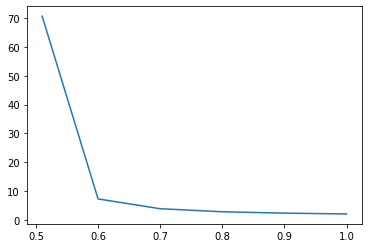

In [50]:
plt.plot([x[0] for x in arr[3:]], [x[5] for x in arr[3:]])